In [16]:
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
#добавим предварительную обработку фото и их нормализацию

In [4]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


выведем первые 10 фоток из датасеты с их метками

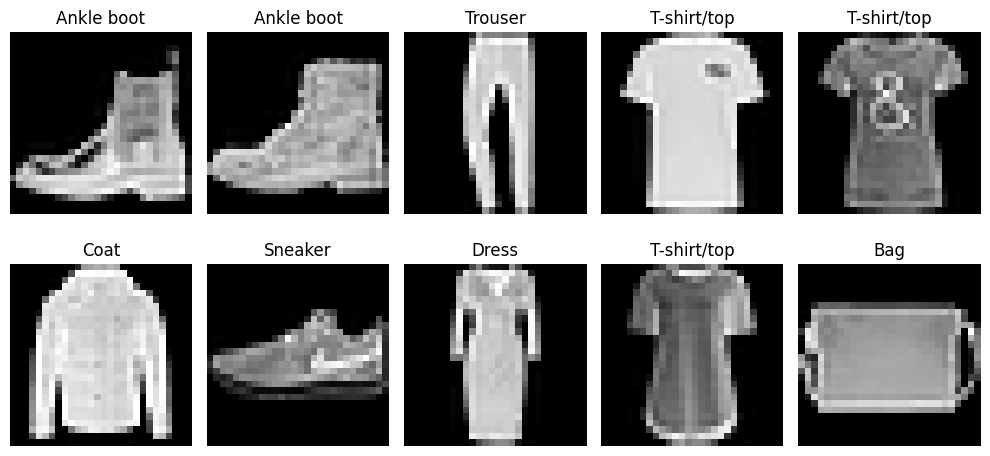

In [22]:
plt.figure(figsize=(10, 5))
for i in range(10):
    image, label = train_dataset[i]
    
    image = image.squeeze().numpy()
    image = (image * 0.5) + 0.5  
    
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

разделим датасет на тестовую и обучающую выборку

In [10]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True);
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False);

создадим простую полносвязную сеть

In [17]:
model = nn.Sequential(
    nn.Flatten(),          
    nn.Linear(784, 128),  
    nn.ReLU(),
    nn.Linear(128, 10)     
)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [13]:
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [14]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

epochs = 15

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss_value = train_running_loss / len(train_loader)
    train_accuracy_value = 100 * train_correct / train_total
    train_loss.append(train_loss_value)
    train_accuracy.append(train_accuracy_value)
    
    # Валидация
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss_value = val_running_loss / len(test_loader)
    val_accuracy_value = 100 * val_correct / val_total
    val_loss.append(val_loss_value)
    val_accuracy.append(val_accuracy_value)
    
    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss_value:.4f}, Train Acc: {train_accuracy_value:.2f}% | '
          f'Val Loss: {val_loss_value:.4f}, Val Acc: {val_accuracy_value:.2f}%')

Epoch 1/15: Train Loss: 0.5659, Train Acc: 79.28% | Val Loss: 0.4195, Val Acc: 84.98%
Epoch 2/15: Train Loss: 0.4112, Train Acc: 85.06% | Val Loss: 0.3857, Val Acc: 86.00%
Epoch 3/15: Train Loss: 0.3733, Train Acc: 86.32% | Val Loss: 0.3904, Val Acc: 85.61%
Epoch 4/15: Train Loss: 0.3464, Train Acc: 87.31% | Val Loss: 0.3475, Val Acc: 87.40%
Epoch 5/15: Train Loss: 0.3261, Train Acc: 88.16% | Val Loss: 0.3416, Val Acc: 87.53%
Epoch 6/15: Train Loss: 0.3092, Train Acc: 88.52% | Val Loss: 0.3473, Val Acc: 87.45%
Epoch 7/15: Train Loss: 0.2990, Train Acc: 88.90% | Val Loss: 0.3608, Val Acc: 87.11%
Epoch 8/15: Train Loss: 0.2844, Train Acc: 89.55% | Val Loss: 0.3282, Val Acc: 87.96%
Epoch 9/15: Train Loss: 0.2755, Train Acc: 89.86% | Val Loss: 0.3460, Val Acc: 87.37%
Epoch 10/15: Train Loss: 0.2666, Train Acc: 90.19% | Val Loss: 0.3329, Val Acc: 87.62%
Epoch 11/15: Train Loss: 0.2579, Train Acc: 90.41% | Val Loss: 0.3398, Val Acc: 87.58%
Epoch 12/15: Train Loss: 0.2498, Train Acc: 90.73% |

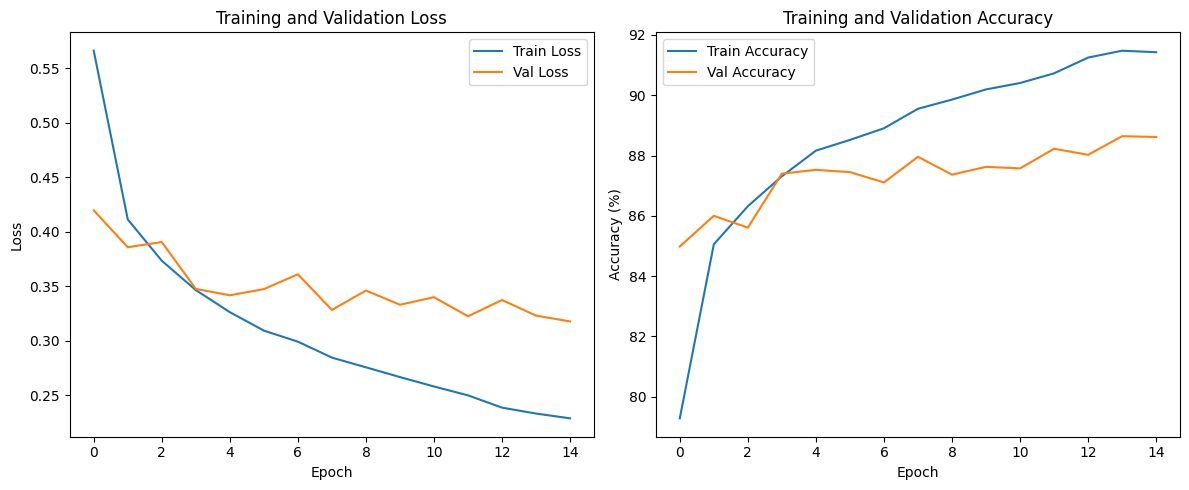

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

вывод: по графикам видно, что loss на валидационных данных растет а accuracy наоборот падает, и можно сделать вывод, что полносвязные сети не совсем хорошо подходят для работы с изображениями

<b>Часть 2. использование сверточных слоев в текущей архитектуре<b>

в нашу модель добавим 2 слоя свертки, с pooling

In [6]:
model_with_cnn = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(64*7*7, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 10)
)

In [8]:
summary(model_with_cnn, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─ReLU: 1-5                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 128]                  401,536
├─ReLU: 1-9                              [1, 128]                  --
├─Dropout: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0


In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_val_loss = float('inf')
patience = 5
no_improve = 0

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss/len(train_loader)
    train_acc = 100*correct/total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss/len(test_loader)
    val_acc = 100*correct/total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss - 0.001:  
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_cnn_model.pth')
    else:
        no_improve += 1
    
    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
    
    if no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        model.load_state_dict(torch.load('best_cnn_model.pth'))
        break

Epoch 1/30: Train Loss: 0.4135, Acc: 84.86% | Val Loss: 0.4112, Acc: 85.24%
Epoch 2/30: Train Loss: 0.3725, Acc: 86.32% | Val Loss: 0.4031, Acc: 85.46%
Epoch 3/30: Train Loss: 0.3461, Acc: 87.42% | Val Loss: 0.3793, Acc: 86.08%
Epoch 4/30: Train Loss: 0.3260, Acc: 88.06% | Val Loss: 0.3586, Acc: 87.01%
Epoch 5/30: Train Loss: 0.3107, Acc: 88.58% | Val Loss: 0.3542, Acc: 87.32%
Epoch 6/30: Train Loss: 0.2968, Acc: 89.02% | Val Loss: 0.3237, Acc: 88.35%
Epoch 7/30: Train Loss: 0.2852, Acc: 89.47% | Val Loss: 0.3345, Acc: 88.16%
Epoch 8/30: Train Loss: 0.2742, Acc: 89.80% | Val Loss: 0.3151, Acc: 88.85%
Epoch 9/30: Train Loss: 0.2647, Acc: 90.10% | Val Loss: 0.3376, Acc: 87.88%
Epoch 10/30: Train Loss: 0.2562, Acc: 90.43% | Val Loss: 0.3213, Acc: 88.71%
Epoch 11/30: Train Loss: 0.2479, Acc: 90.67% | Val Loss: 0.3284, Acc: 88.24%
Epoch 12/30: Train Loss: 0.2405, Acc: 91.06% | Val Loss: 0.3214, Acc: 88.49%
Epoch 13/30: Train Loss: 0.1971, Acc: 92.79% | Val Loss: 0.2918, Acc: 89.81%
Epoch 14

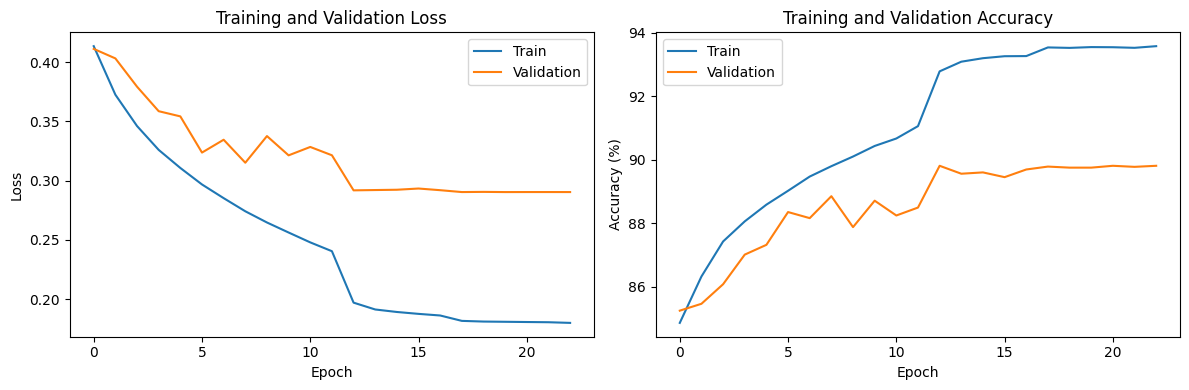

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation') 
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

можно сделать вывод, что с добавлением слоев свертки нам удалось добиться уменьшения loss на валидации и увеличении точности самой модели, а также графики стали плавнее чем у предыдущей модели